# EfficientNet and Attempt at VGG



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
from keras.optimizers import Adam, SGD
from keras import Sequential
import os, cv2, json
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import Flatten, Dense, Dropout
from tensorflow.image import crop_and_resize
from tensorflow.keras.applications.efficientnet import preprocess_input


# ignoring warnings
import warnings
warnings.simplefilter("ignore")

In [2]:
# For easy acces to files
directory = "../input/cassava-leaf-disease-classification/"
with open('../input/cassava-leaf-disease-classification/label_num_to_disease_map.json', 'r') as file:
    labels = json.load(file)
data = pd.read_csv(directory + "train.csv")

# for data augmentation
data.label = data.label.astype("str")

# Initial Image Visualization

In [3]:
img_size = 256

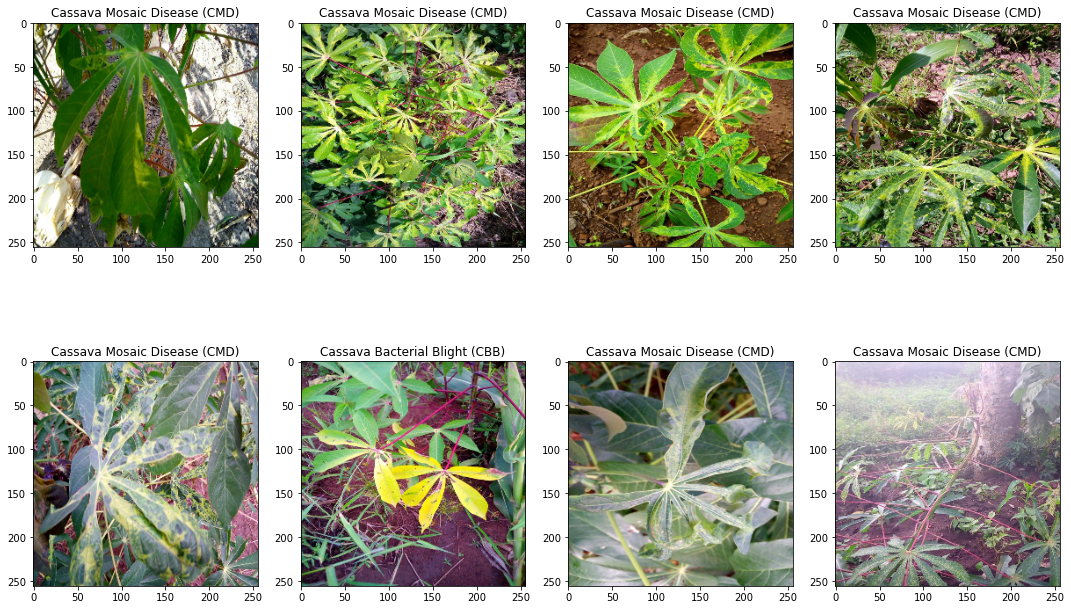

In [4]:
plt.figure(figsize=(15,10))
data_sample = data.sample(9).reset_index(drop=True)

for i in range(8):
    plt.subplot(2,4,i + 1)
    
    img = cv2.imread(directory + "train_images/" + data_sample.image_id[i])
    img = cv2.resize(img, (img_size, img_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img)
    plt.title(labels.get(data_sample.label[i]))
    
plt.tight_layout()
plt.show()

# VGG Work





In [5]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical


x_train,x_val,y_train,y_val = train_test_split(data.image_id,data.label,test_size=.3)
#x_train.shape
#x_val.shape
#x_val
#y_train.shape

y_train=to_categorical(y_train)
y_val=to_categorical(y_val)

y_val.shape

(6420, 5)

# ImageDataGenerator/Data Augmentation

use **ImageDataGenerator:** and **flow_from_dataframe:** to do data augmentation



In [6]:

train_generator = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, shear_range=25,
                                    zoom_range=0.3, horizontal_flip=True, vertical_flip=True,
                                    validation_split=0.2) \
        .flow_from_dataframe(data, directory = directory + "train_images", x_col = "image_id", y_col = "label",
                            target_size = (img_size, img_size), class_mode = "categorical",
                            batch_size = 32, shuffle = True, subset = "training")

valid_generator = ImageDataGenerator(validation_split = 0.2) \
        .flow_from_dataframe(data, directory = directory + "train_images", x_col = "image_id",
                            y_col = "label", target_size = (img_size, img_size), class_mode = "categorical",
                            batch_size = 32, shuffle = True, subset = "validation")


Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


# VGG

This iteration didn't quite work, so I turned to EfficientNet

https://stackoverflow.com/questions/57405278/how-to-use-first-10-layers-of-pre-trained-model-like-vgg19-keras

In [7]:
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5)


In [8]:
base_model = VGG19(include_top = False, weights = 'imagenet', input_shape = (224,224,3), classes = y_train.shape[1])

80142336/80134624 [==============================] - 1s 0us/step


In [9]:
model= Sequential()
model.add(base_model) 
model.add(Flatten()) 

model.add(Dense(1024,activation=('relu')))
model.add(Dropout(.2))
model.add(Dense(5,activation=('softmax'))) 

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 45,720,645
Trainable params: 45,720,645
Non-trainable params: 0
_________________________________________________________________


In [11]:
batch_size= 100
epochs=50
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
model.fit_generator(train_generator,epochs = 1, validation_data = valid_generator, validation_steps = 250, callbacks=[lrr], verbose = 1)

InvalidArgumentError:  Input to reshape is a tensor with 1048576 values, but the requested shape requires a multiple of 25088
	 [[node sequential/flatten/Reshape (defined at <ipython-input-12-0634139b841e>:1) ]] [Op:__inference_train_function_1913]

Function call stack:
train_function


# EfficientNet

This one worked much better than VGG, achieving 80+% accuracy on the given dataset
The added layers that I used were based on the link below:

Resources: https://www.dlology.com/blog/transfer-learning-with-efficientnet/


In [13]:
model = models.Sequential()
conv_base = EfficientNetB0(include_top = False, weights = "imagenet", input_shape=(img_size, img_size, 3))
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D(name="gap"))
model.add(layers.Dense(5, activation = "softmax"))

16711680/16705208 [==============================] - 0s 0us/step


In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 8, 8, 1280)        4049571   
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 6405      
Total params: 4,055,976
Trainable params: 4,013,953
Non-trainable params: 42,023
_________________________________________________________________


## Diagram of the Model

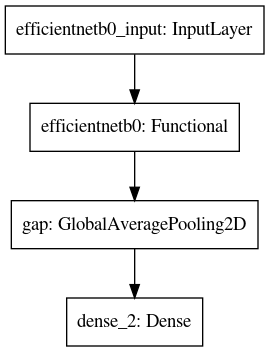

In [15]:
from tensorflow.keras import utils

utils.plot_model(model)

## Using Callbacks

**ModelCheckpoint** saves the weights at a certain frequency, **EarlyStopping** stops the training process when the validation loss stops improving, and **ReduceLROnPlateau** reduces the learning rate when validation loss stops improving.


https://keras.io/api/callbacks/

In [16]:
checkpoint = ModelCheckpoint("./currentModel.h5", monitor = "val_loss", verbose = 1,
                            save_best_only = True, save_weights_only = False, mode = "min")
earlystop= EarlyStopping(monitor = "val_loss",min_delta = 0.001, patience = 3,
                        verbose = 1, mode = "min", restore_best_weights = False)
rlr= ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3,
                                verbose=1, mode="min", min_delta=0.0001)

In [17]:
# compiling the model
model.compile(optimizer="adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [18]:
# train the model using the augmented data from before 
history = model.fit_generator(train_generator, epochs = 10, validation_data = valid_generator,
                             callbacks = [checkpoint, earlystop, rlr])


Epoch 1/10
535/535 [==============================] - ETA: 0s - loss: 0.6557 - accuracy: 0.7674
Epoch 00001: val_loss improved from inf to 0.60453, saving model to ./currentModel.h5
535/535 [==============================] - 550s 1s/step - loss: 0.6557 - accuracy: 0.7674 - val_loss: 0.6045 - val_accuracy: 0.7817
Epoch 2/10
535/535 [==============================] - ETA: 0s - loss: 0.5241 - accuracy: 0.8134
Epoch 00002: val_loss did not improve from 0.60453
535/535 [==============================] - 463s 865ms/step - loss: 0.5241 - accuracy: 0.8134 - val_loss: 0.6253 - val_accuracy: 0.7567
Epoch 3/10
535/535 [==============================] - ETA: 0s - loss: 0.4846 - accuracy: 0.8304
Epoch 00003: val_loss improved from 0.60453 to 0.55529, saving model to ./currentModel.h5
535/535 [==============================] - 463s 865ms/step - loss: 0.4846 - accuracy: 0.8304 - val_loss: 0.5553 - val_accuracy: 0.8014
Epoch 4/10
535/535 [==============================] - ETA: 0s - loss: 0.4592 - accu

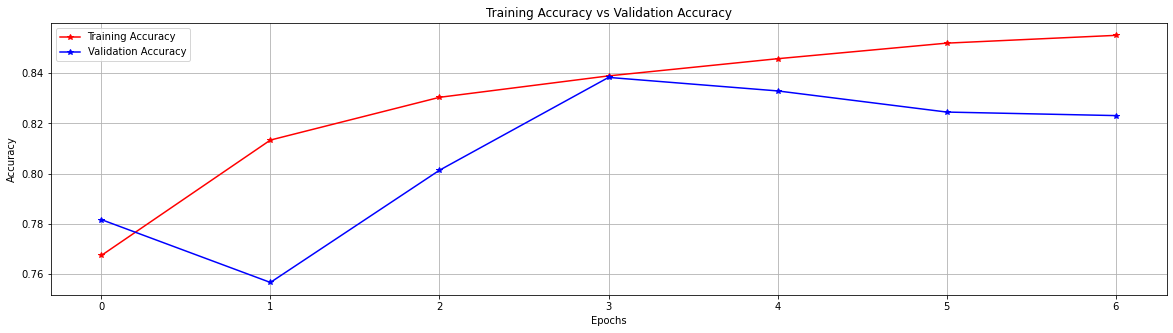

In [19]:
plt.figure(figsize=(20, 5))
plt.plot(history.history['accuracy'], 'r*-', label="Training Accuracy")
plt.plot(history.history['val_accuracy'], 'b*-', label="Validation Accuracy")
plt.grid()
plt.title("Training Accuracy vs Validation Accuracy")

plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

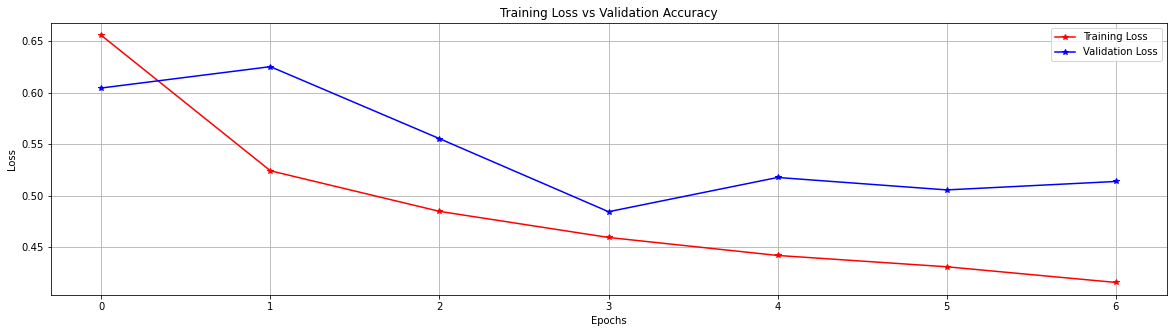

In [20]:
plt.figure(figsize=(20, 5))
plt.plot(history.history['loss'], 'r*-', label="Training Loss")
plt.plot(history.history['val_loss'], 'b*-', label="Validation Loss")
plt.grid()
plt.title("Training Loss vs Validation Accuracy")

plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

**Any suggestions are very valuable to me. please share with me**